In [22]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import math
import mpmath as mp
mp.dps = 500
from sklearn.linear_model import Lasso

list_pval = []


In [23]:
def compute_etaj_etajTy(j_selected, active, active_X, y):    
    ej = []
    for each_j in active:
        if j_selected == each_j:
            ej.append(1)
        else:
            ej.append(0)

    ej = np.array(ej).reshape((len(active), 1))

    etaj = np.linalg.pinv(active_X).T @ ej
    # print(etaj.shape)
    etajTy = np.dot(etaj.T, y)[0]

    return etaj, etajTy

def compute_AB(active_X, inactive_X, lambda_param, s):
    P = active_X @ np.linalg.pinv(active_X.T @ active_X) @ active_X.T
    A0 = [inactive_X.T @ (np.identity(P.shape[0]) - P), 
          - inactive_X.T @ (np.identity(P.shape[0]) - P)]
    A0 = 1/lambda_param * np.array(A0)
    b0 = [1 - inactive_X.T @ np.linalg.pinv(active_X.T) @ s, 
          1 + inactive_X.T @ np.linalg.pinv(active_X.T) @ s]
    b0 = np.array(b0)
    b0 = b0.reshape((2, b0.shape[1], 1))
    A1 = -np.array(np.diag(s) @ np.linalg.inv(active_X.T @ active_X) @ active_X.T)
    b1 = -lambda_param * np.array(np.diag(s) @ np.linalg.inv(active_X.T @ active_X) @ s)
    b1 = b1.reshape((-1, 1))
    A = np.vstack((np.vstack((A0[0], A0[1])), A1))
    b = np.vstack((np.vstack((b0[0], b0[1])), b1))
    return A, b

def compute_c_z(eta, cov, active, y, n):
    c = cov @ eta @ np.linalg.pinv(eta.T @ cov @ eta)
    z = (np.identity(n) - c @ eta.T) @ y
    c = np.array(c)
    z = np.array(z)
    print(c.shape)
    return c, z

def check_kkt(active_X, inactive_X, active_coef, lambda_param, y, s):
    print('check active:')
    s = active_X.T @ (y - active_X @ active_coef) 
    print(s/lambda_param)

    print('check inactive:')
    s = inactive_X.T @ (y - active_X @ active_coef)
    print(s/lambda_param)

def run():
    # np.random.seed(42)
    n, p = 100, 10
    true_beta = np.zeros(p)
    true_beta[:3] = 1
    X = np.random.randn(n, p)
    sigma = 1
    cov = np.identity(n)
    y = X @ true_beta.T + np.random.normal(0, 1, n)
    true_y = X @ true_beta.T
    lambda_param = 5
    lasso = Lasso(alpha=lambda_param/n, fit_intercept=False, max_iter=1000000)
    lasso.fit(X, y)
    coef = lasso.coef_
    # print(coef)
    active = []
    inactive = []
    for i in range(len(coef)):
        if coef[i] != 0:
            active.append(i)
        else:
            inactive.append(i)
    if (len(active) == 0):
        return
    active_X = X[:, active]
    active_coef = coef[active]
    inactive_X = X[:, inactive]
    inactive_coef = coef[inactive]
    s = np.array(np.sign(active_coef))
    check_kkt(active_X, inactive_X, active_coef, lambda_param, y, s)
    A, b = compute_AB(active_X, inactive_X, lambda_param, s)
    for j in active:
        # rand_value = np.random.randint(len(active))
        # j = active[rand_value]
        etaj, etajTy = compute_etaj_etajTy(j, active, active_X, y)
        c, z = compute_c_z(etaj, cov, active, y, n)
        # print(etaj)
        Vminus = [-np.inf]
        Vplus = [np.inf]
        for i in range(len(A)):
            Ac = A[i] @ c
            Az = A[i] @ z
            # if (-1e10 <= Ac <= 1e10):
            #     Ac = 0
            if Ac < 0:
                Vminus = max(Vminus, (b[i] - Az) / Ac)
            elif Ac > 0:
                Vplus = min(Vplus, (b[i] - Az) / Ac)
        if (Vminus > Vplus):
            continue
        Vminus = Vminus[0]
        Vplus = Vplus[0]
        mu = (etaj.T @ true_y)[0]
        sigma = np.sqrt((etaj.T @ cov @ etaj)[0][0])
        print('sigma:', sigma)
        numerator = mp.ncdf((etajTy - mu) / sigma) - mp.ncdf((Vminus - mu) / sigma)
        denominator = mp.ncdf((Vplus - mu) / sigma) - mp.ncdf((Vminus - mu) / sigma)
        if denominator <= 1e-16:
            true_cdf = 1
        else:
            true_cdf = numerator / denominator 
        # print((Vminus - mu) / sigma, (etajTy - mu) / sigma, (Vplus - mu) / sigma)
        # print(true_cdf)
        p_value = float(2 * min(true_cdf, 1 - true_cdf))
        list_pval.append(p_value)
        print(f'p_value of index {j}: {p_value}')
        # break


check active:
[ 0.99997293  1.00003605  0.99999828  0.99999281  0.99998296  0.99998757
 -1.00000382 -1.        ]
check inactive:
[0.81428156 0.24413472]
(100, 1)
sigma: 0.11420882838504155
p_value of index 0: 0.2823480426591991
(100, 1)
sigma: 0.1010050842269748
p_value of index 1: 0.8120197059656801
(100, 1)
sigma: 0.09949472690083068
p_value of index 2: 0.05992547137305704
(100, 1)
sigma: 0.09611899882703984
p_value of index 4: 0.35766727987371927
(100, 1)
sigma: 0.11243083435114525
p_value of index 6: 0.25905842086016406
(100, 1)
sigma: 0.09649390445714014
p_value of index 7: 0.4902919674994597
(100, 1)
sigma: 0.09697258828249349
p_value of index 8: 0.11818782519175763
(100, 1)
sigma: 0.11053940273564199
p_value of index 9: 0.8364150819114833
check active:
[ 0.99979707  0.99978956  1.00005623 -0.99992657  1.00002306 -1.00004514
 -1.00001506  0.99999949 -1.        ]
check inactive:
[0.41159244]
(100, 1)
sigma: 0.10854077047704119
p_value of index 0: 0.6870613026766392
(100, 1)
sigma:

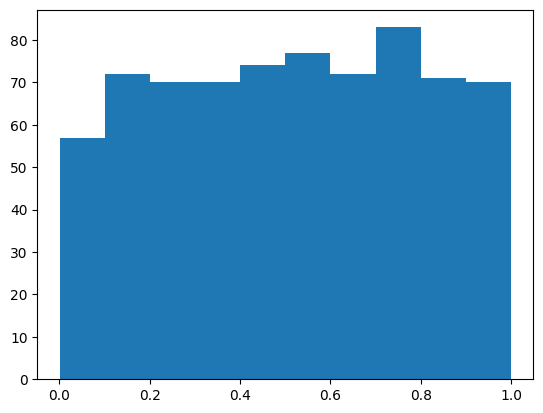

In [24]:
for _ in range(100):
    run()
plt.hist(list_pval)
plt.show()
